# Assignment 3: Allocation to Performance-Seeking Portfolios versus Liability- or Goal-Hedging Portfolios


### Importation of modules

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

### Data inspection (the data will be use for the 3 problems)

In [2]:
data=pd.read_excel("data_CPPI.xlsx")
data

,Name,S&P 500 COMPOSITE - TOT RETURN IND
0,2015-01-06,3667.14
1,2015-01-13,3706.15
2,2015-01-20,3705.64
3,2015-01-27,3718.99
4,2015-02-03,3757.34
...,...,...
253,2019-11-12,6253.91
254,2019-11-19,6314.66
255,2019-11-26,6358.46
256,2019-12-03,6265.22


### Data inspection:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 2 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Name                                258 non-null    datetime64[ns]
 1   S&P 500 COMPOSITE - TOT RETURN IND  258 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.2 KB


We see that we have no missing data

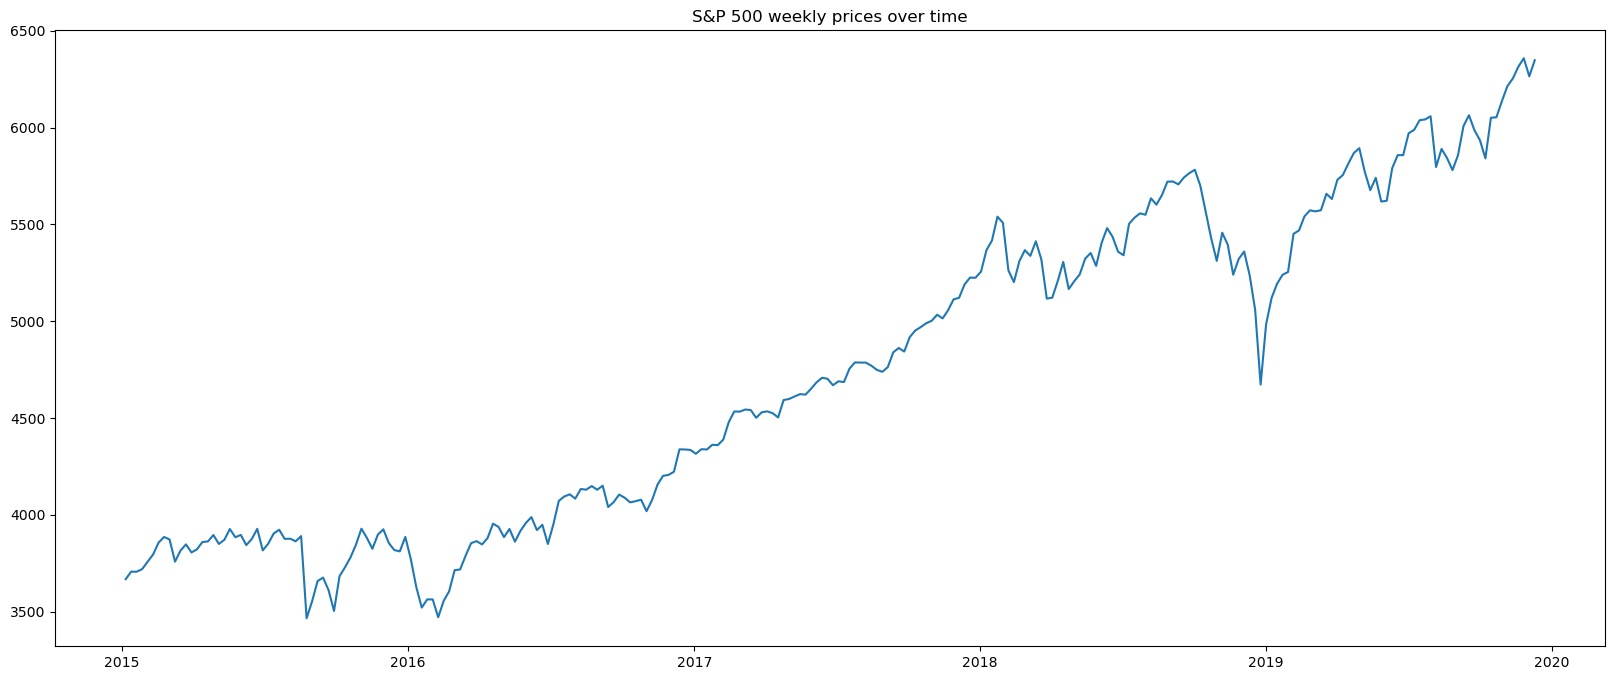

In [4]:
x=data["Name"]
y=data["S&P 500 COMPOSITE - TOT RETURN IND"]
plt.figure(figsize=(20, 8))
plt.plot(x,y)
plt.title("S&P 500 weekly prices over time")
plt.show()

We can see that we have no outliers

### We put the dates as index

In [5]:
data=data.set_index(["Name"])
data

,S&P 500 COMPOSITE - TOT RETURN IND
Name,
2015-01-06,3667.14
2015-01-13,3706.15
2015-01-20,3705.64
2015-01-27,3718.99
2015-02-03,3757.34
...,...
2019-11-12,6253.91
2019-11-19,6314.66
2019-11-26,6358.46


## Problem 3 (Time Varying Multiplier)

### Define CPPI strategy with time-varying multiplier

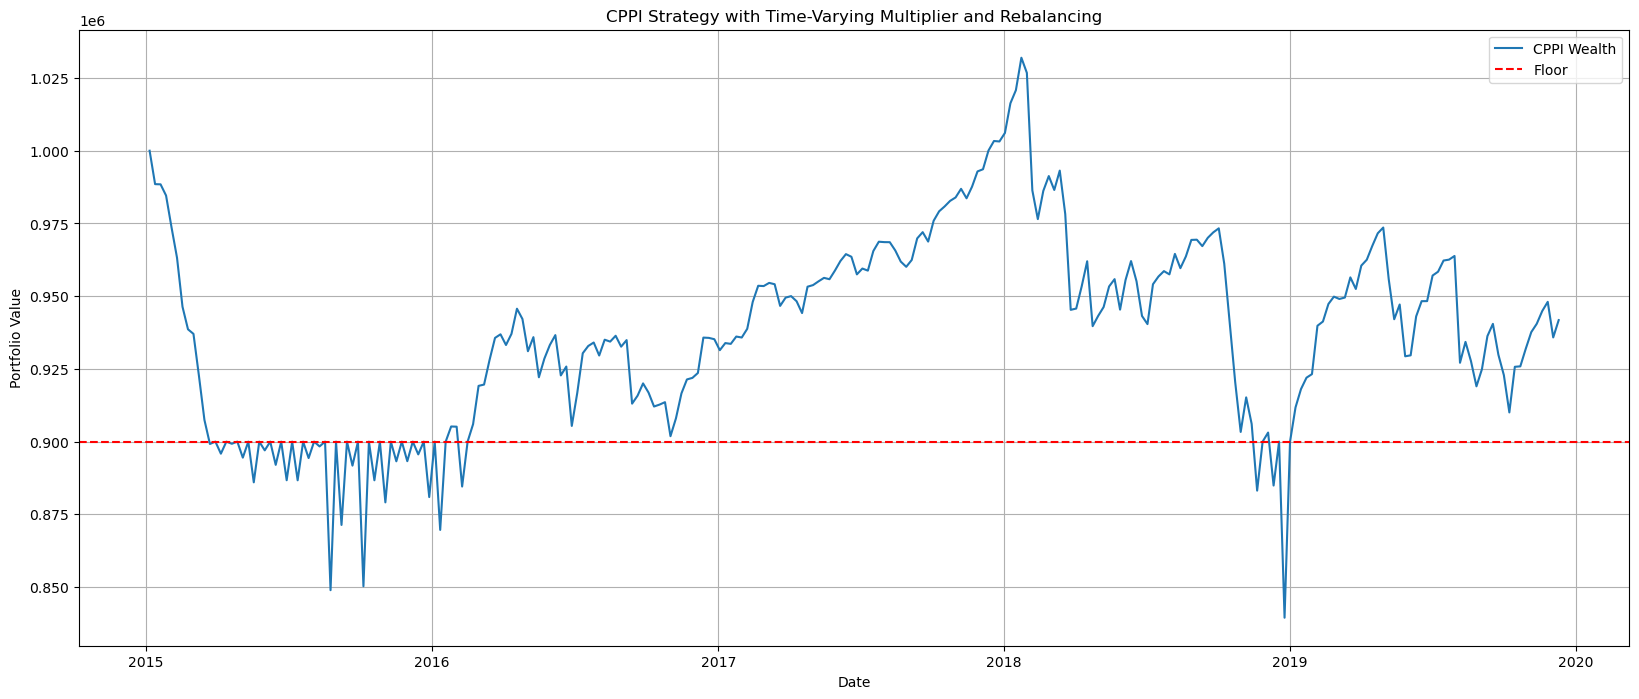

The final Portfolio Value is: $ 941771.58


In [6]:
def cppi_with_time_varying_multiplier(prices, initial_wealth, floor, volatility_window, long_term_horizon, short_term_horizon):
    wealth = np.zeros_like(prices) # Create a vector full of zeros with the same length than prices
    ratio = np.zeros_like(prices) # Create a vector full of zeros with the same length than prices
    multiplier = np.ones_like(prices)  # Initialize with a default multiplier of 1
    wealth[0] = initial_wealth  # Initial wealth
    ratio[0] = 1.0  # Initial  ratio

    for t in range(1, len(prices)): # We calculate for each date
        returns = prices.pct_change().iloc[max(0, t - volatility_window):t] # Calculate the returns
        volatility = returns.std() * np.sqrt(52)  # Annualized volatility for weekly data
        if t < short_term_horizon: 
            multiplier[t] = 1.6  # Short-term horizon multiplier
        elif t < long_term_horizon:
            multiplier[t] = 0.40  # Long-term horizon multiplier
        if volatility > 0.3:  # threshold for high volatility
            multiplier[t] *= 0.6  # Reduce multiplier for high volatility
        elif volatility<0.03: # threshold for low volatility
            multiplier[t] *= 1.7 # Increase multiplier for low volatility
        if prices.iloc[t] > prices.iloc[t - 1]:  # Bull market condition
            multiplier[t] *= 1.3 # Increase multiplier in bull market
        else:  # Bear market condition
            multiplier[t] *= 0.3 # Decrease multiplier in bear market

        ratio[t] = (wealth[t - 1] - floor) / wealth[t - 1] # Calculate the new ratio
        if ratio[t] < 0:
            # If ratio is negative, set the portfolio value equal to the floor, we need to rebalance
            wealth[t] = floor
        else:
            risk_budget = multiplier[t] * wealth[t - 1]
            wealth[t] = risk_budget + (wealth[t - 1] - risk_budget) * (1 + (prices.iloc[t] - prices.iloc[t - 1]) / prices.iloc[t - 1])

    return wealth

# Parameters:
initial_wealth = 1000000
floor = 0.9*initial_wealth
volatility_window = 30  # Number of weeks for volatility calculation
long_term_horizon = 20 * 52  # Number of weeks for long-term
short_term_horizon = 1 * 52  # Number of weeks for short term
prices=data["S&P 500 COMPOSITE - TOT RETURN IND"]

# Simulate the CPPI with a time-varying multiplier:
wealth = cppi_with_time_varying_multiplier(prices, initial_wealth,floor, volatility_window, long_term_horizon, short_term_horizon)

# Plot results:
plt.figure(figsize=(20, 8))
plt.plot(prices.index, wealth, label="CPPI Wealth")
plt.axhline(y=floor, color='r', linestyle='--', label="Floor")
plt.title("CPPI Strategy with Time-Varying Multiplier and Rebalancing")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()
print("The final Portfolio Value is: $",round(wealth[-1],2))

## Problem 4 (Maximum Drawdown)

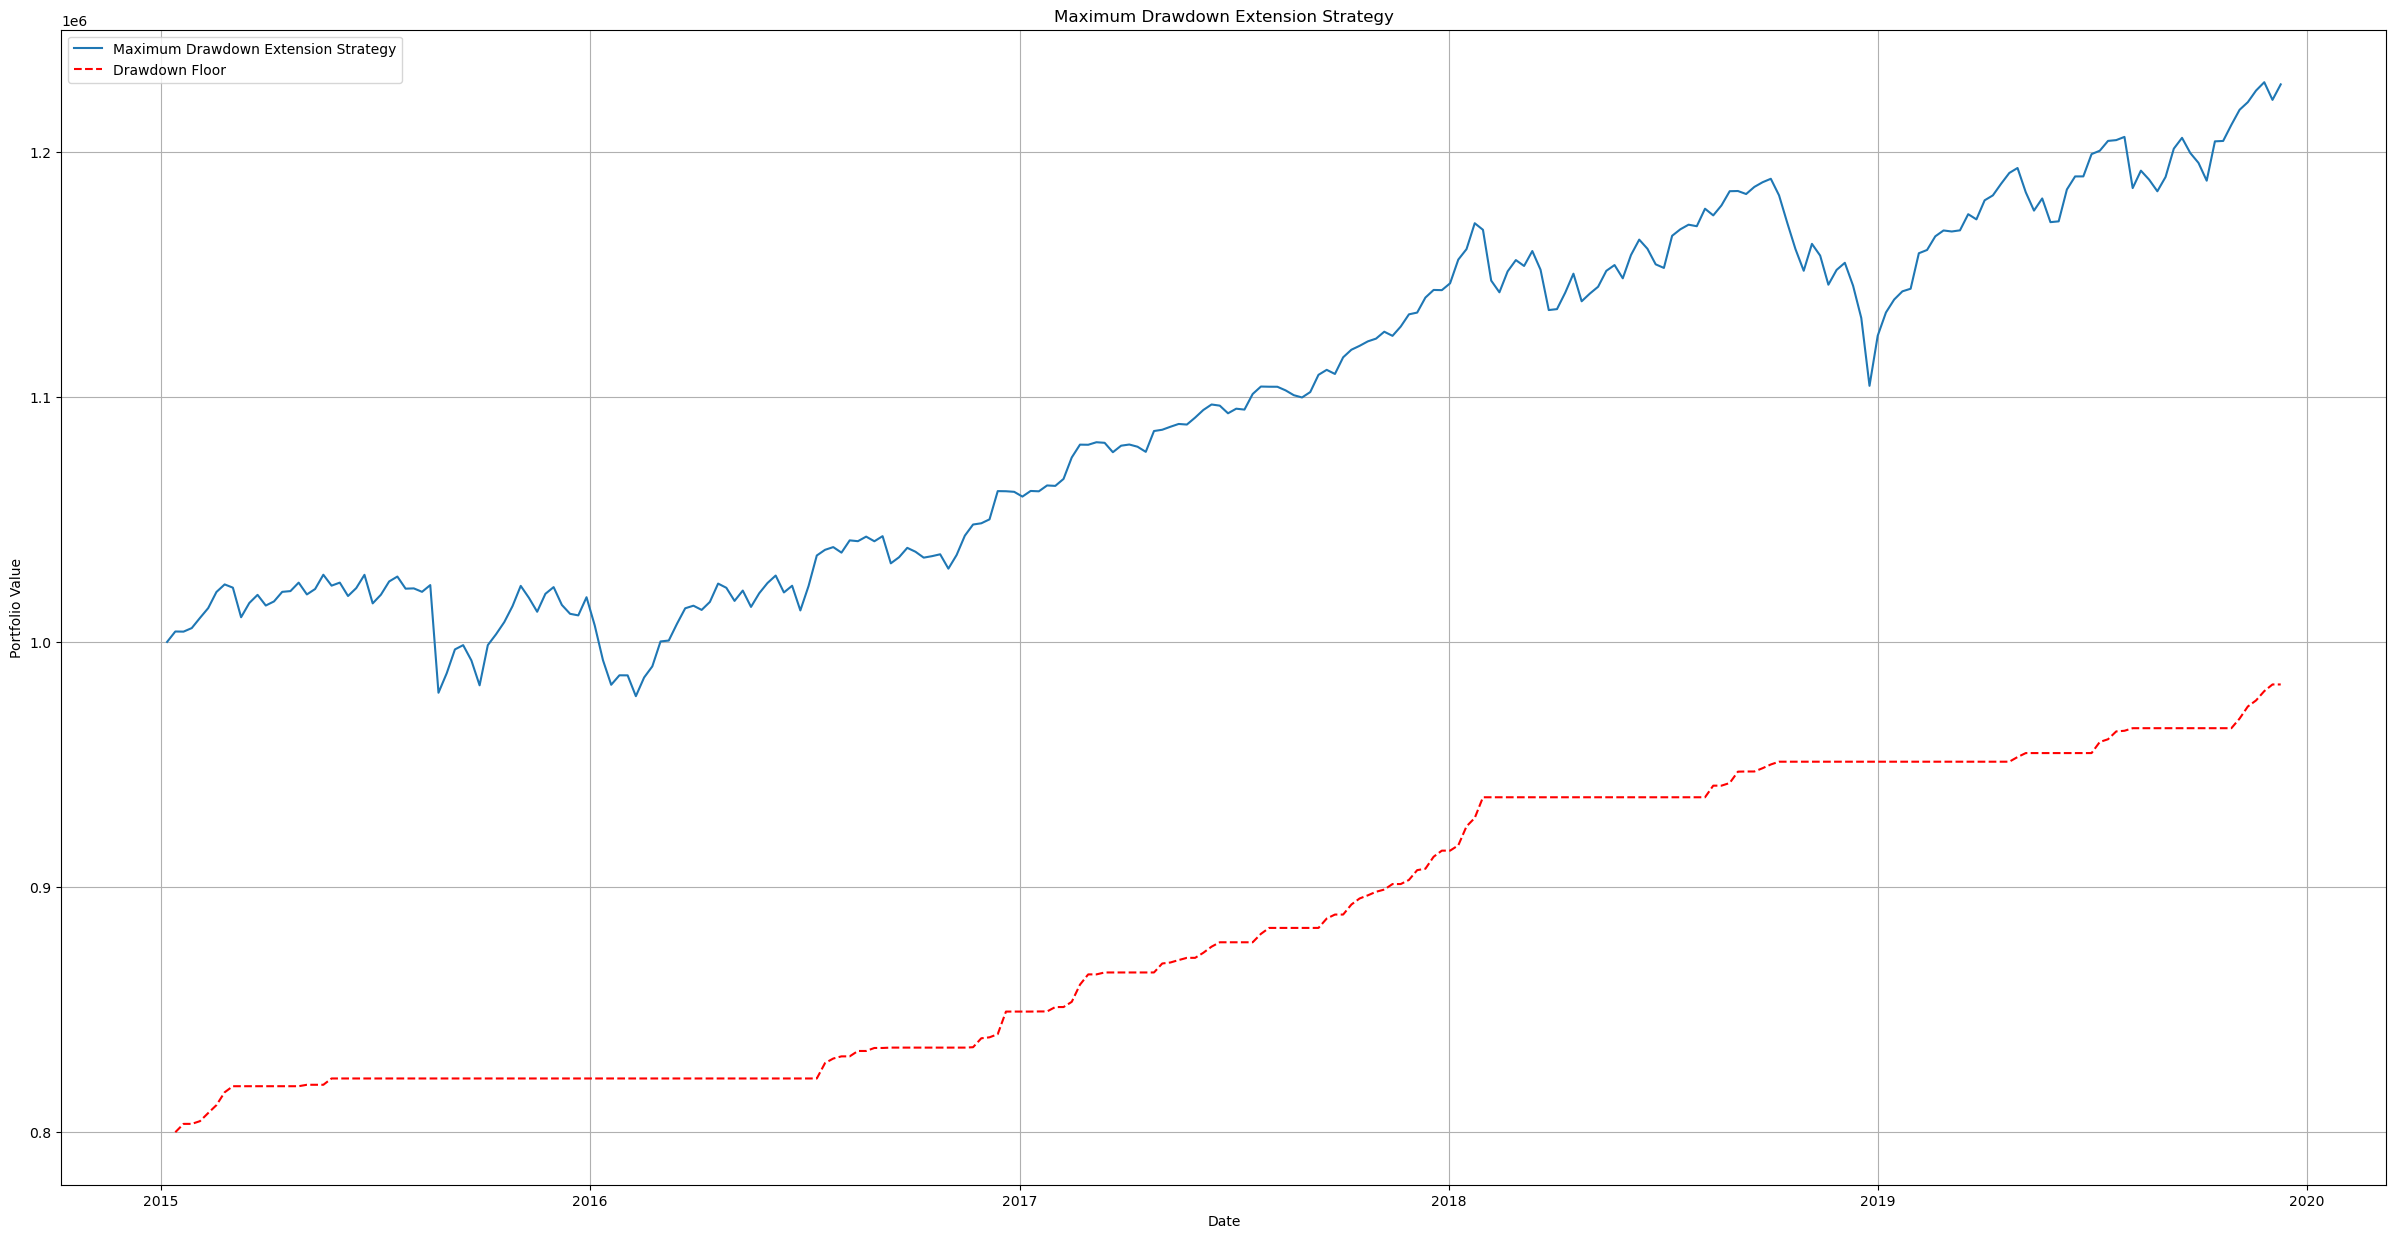

The final Portfolio Value is: $ 1227434.68


In [7]:
def max_drawdown_extension_strategy(prices, initial_value,max_acceptable_drawdown, multiplier):
    returns=prices.pct_change() # Calculate the returns
    portfolio_value = np.ones_like(returns) # Create a vector full of ones with the same lenght than returns
    running_max = np.ones_like(returns) # Create a vector full of ones with the same lenght than returns
    portfolio_value[0] = initial_value # Initialize with the initial portfolio value
    drawdown_floor_list=[0]
    for t in range(1, len(returns)): # We look at all the dates
        running_max[t] = max(running_max[t-1], portfolio_value[t-1]) # We compute the running maximum at each date
        drawdown_floor = running_max[t] * (1 - max_acceptable_drawdown) # We compute the drawdown_floor
        ratio = multiplier*(portfolio_value[t-1] - drawdown_floor) # We compute the ratio
        drawdown_floor_list.append(drawdown_floor) # Add the floor value to a list
        if ratio > 0:
            risky_asset_allocation = ratio  # Invest in risky asset
        else:
            risky_asset_allocation = 0  # Invest nothing in risky asset
        
        portfolio_value[t] = risky_asset_allocation * (1 + returns[t]) + (portfolio_value[t-1] - risky_asset_allocation) # Compute the new portfolio value
        
    return portfolio_value,drawdown_floor_list


# Parameters:
initial_value=1000000
prices=data["S&P 500 COMPOSITE - TOT RETURN IND"]
max_acceptable_drawdown = 0.2  # Maximum acceptable drawdown at the end of the protection period
multiplier=2

# Simulate Maximum Drawdown extension strategy:
portfolio_value_max_drawdown = max_drawdown_extension_strategy(prices, initial_value,max_acceptable_drawdown, multiplier)

# Plot results:
plt.figure(figsize=(30, 15))
plt.plot(prices.index,portfolio_value_max_drawdown[0], label='Maximum Drawdown Extension Strategy')
plt.plot(prices.index[1:],portfolio_value_max_drawdown[1][1:], color='r', linestyle='--', label="Drawdown Floor")
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Maximum Drawdown Extension Strategy')
plt.legend()
plt.grid(True)
plt.show()

print("The final Portfolio Value is: $",round(portfolio_value_max_drawdown[0][-1],2))

## Problem 5 (CPPI with Cap)

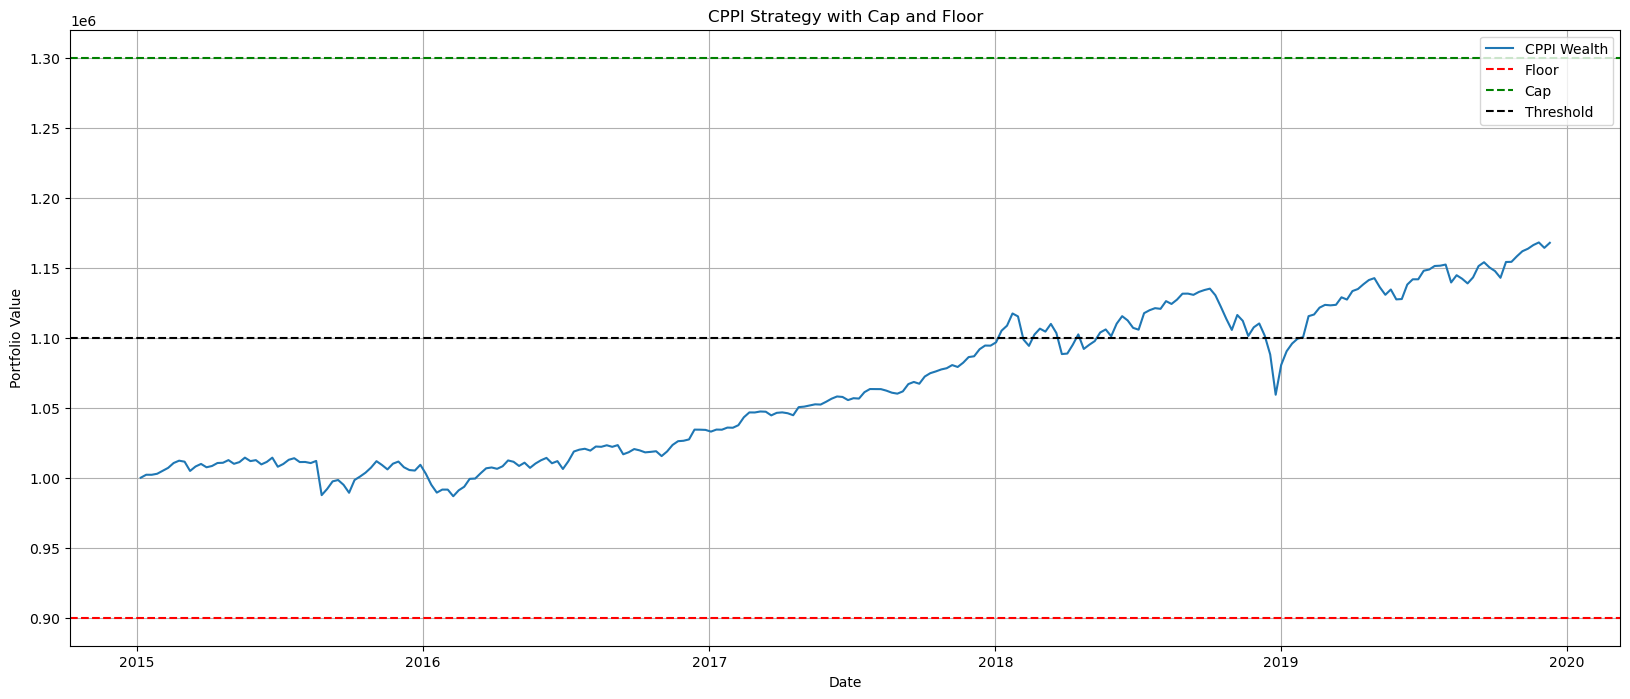

The final Portfolio Value is: $ 1167792.9


In [11]:
def cppi_with_cap(prices, initial_wealth, floor, cap,multiplier):
    wealth = np.zeros_like(prices) # Create a vector full of zeros with the same length than prices
    ratio = np.zeros_like(prices) # Create a vector full of zeros with the same length than prices
    wealth[0] = initial_wealth  # Initial wealth
    ratio[0] = 1.0  # Initial  ratio
    threshold = (floor + cap) / 2 # Compute the threshold
    for t in range(1, len(prices)): # We calculate for each date
        returns = prices.pct_change() # Calculate the returns

        if wealth[t-1] <= threshold and wealth[t-1]>=floor: # If we are between the floor and the threshold
            risky_asset_allocation=multiplier*(wealth[t-1]-floor)
        elif wealth[t-1] <= cap and wealth[t-1]>=threshold: # If we are between the threshold and the cap
            risky_asset_allocation=multiplier*(cap-wealth[t-1])
        else:
            risky_asset_allocation=multiplier*(threshold-wealth[t-1])
            
        wealth[t] = risky_asset_allocation * (1 + returns[t]) + (wealth[t-1] - risky_asset_allocation) # New portfolio value
    return wealth

# Parameters:
initial_value=1000000
prices=data["S&P 500 COMPOSITE - TOT RETURN IND"]
floor = 0.9*initial_value 
cap=1.3*initial_value
multiplier=2

# Simulate the CPPI with a cap and a floor:
wealth= cppi_with_cap(prices, initial_wealth, floor, cap,multiplier)  


# Plot results:
plt.figure(figsize=(20, 8))
plt.plot(prices.index, wealth, label="CPPI Wealth")
plt.axhline(y=floor, color='r', linestyle='--', label="Floor")
plt.axhline(y=cap, color='g', linestyle='--', label="Cap")
plt.axhline(y=(cap+floor)/2, color='black', linestyle='--', label="Threshold")
plt.title("CPPI Strategy with Cap and Floor")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()
print("The final Portfolio Value is: $",round(wealth[-1],2))